In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import visionloader as vl
from sklearn.cluster import SpectralClustering
import os
import src.fitting as fitting
import src.multielec_utils as mutils
import src.old_labview_data_reader as oldlv
from mpl_toolkits.mplot3d import Axes3D
import cvxpy as cp
from scipy.optimize import minimize
import statsmodels.api as sm
import operator as op
import itertools as it

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

In [2]:
# Current values in uA

Ivals = np.array([0.10053543, 0.11310236, 0.11938583, 0.13195276, 0.14451969,                        
                       0.16337008, 0.17593701, 0.1947874 , 0.2136378 , 0.23877165,
                       0.25762205, 0.2780315 , 0.30330709, 0.35385827, 0.37913386,
                       0.42968504, 0.45496063, 0.50551181, 0.55606299, 0.60661417,
                       0.68244094, 0.73299213, 0.8088189 , 0.88464567, 0.98574803,
                       1.10433071, 1.20472441, 1.30511811, 1.40551181, 1.60629921,
                       1.70669291, 1.90748031, 2.10826772, 2.30905512, 2.50984252,
                       2.81102362, 3.11220472, 3.41338583, 3.71456693, 4.1161])

In [3]:
ANALYSIS_BASE = "/Volumes/Analysis"
MATFILE_BASE = "/Volumes/Scratch/Users/praful/triplet_gsort_matfiles_20220420"
gsort_path = "/Volumes/Scratch/Users/praful/newlv_gsort_v2_30um_periphery"
gsort_path_1elec = "/Volumes/Scratch/Users/praful/single_gsort_v2_30um_periphery-affinity_cosine"

In [4]:
dataset = "2020-10-18-5"
estim = "data006/data006-all_v2"
estim_1elec = "data001"
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim)

In [5]:
wnoise = "kilosort_data002/data002"
vis_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)
vis_datarun = wnoise.split('/')[-1]
vcd = vl.load_vision_data(
    vis_datapath,
    vis_datarun,
    include_neurons=True,
    include_ei=True,
    include_params=True,
    include_noise=True,
)

coords = vcd.get_electrode_map()

In [6]:
p = 2
all_cells = np.array([197, 212, 220], dtype=int)

In [7]:
def all_combos(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    powerset = list(it.chain.from_iterable(it.combinations(s, r) for r in range(1, len(s)+1)))
    
    targets = []
    nontargets = []
    for i in powerset:
        for j in powerset:
            if len(np.intersect1d(np.array(i), np.array(j))) == 0:
                targets.append(np.array(i))
                nontargets.append(np.array(j))
                
    return np.array(targets, dtype=object), np.array(nontargets, dtype=object)

In [8]:
def binaryClustering(X, y, T, R2_thr=0.1, min_points_per_cluster=30, child='', verbose=False):
    if verbose:
        print(child)
        print(len(X))
    X_bin_init, y_bin_init = fitting.convertToBinaryClassifier(y, T, X)
    results_init = minimize(fitting.negLL, x0=np.array([-1, 1, 1, 1]), args=(X_bin_init, y_bin_init, False, 'none'))
    nll_MLE_init = results_init.fun

#     log_reg = sm.Logit(y_bin_init, X_bin_init).fit()
    
    ybar = np.mean(y_bin_init)
    beta_null = np.log(ybar / (1 - ybar))
    null_weights = np.concatenate((np.array([beta_null]), np.zeros(X.shape[-1])))
    nll_null = fitting.negLL(null_weights, X_bin_init, y_bin_init, False, 'none')
    
    R2 = 1 - nll_MLE_init / nll_null
#     print(log_reg.summary())

    if verbose:
        print(R2)

    if len(X) >= min_points_per_cluster and R2 >= R2_thr:
        return [(X, y, results_init.x)]
    elif len(X) < min_points_per_cluster:
        return [(X, y, [np.nan])]
    else:
        clustering = SpectralClustering(n_clusters=2, 
                                        assign_labels='discretize',
                                        affinity='nearest_neighbors').fit(X)

        cluster0 = np.where(clustering.labels_ == 0)[0]
        cluster1 = np.where(clustering.labels_ == 1)[0]

   
        return binaryClustering(X[cluster0], y[cluster0], T[cluster0], R2_thr=R2_thr, min_points_per_cluster=min_points_per_cluster, child='left', verbose=verbose) + binaryClustering(X[cluster1], y[cluster1], T[cluster1], R2_thr=R2_thr, min_points_per_cluster=min_points_per_cluster, child='right', verbose=verbose) 

In [9]:
def classifySelectivity(targets, nontargets):
    target_types = np.zeros(len(targets), dtype=bool)
    for i in range(len(targets)):
        t = targets[i]
        cell_type = vcd.get_cell_type_for_cell(t).lower()
        if 'on' in cell_type:
            target_types[i] = True

    nt_types = np.zeros(len(nontargets), dtype=bool)
    for i in range(len(nontargets)):
        nt = nontargets[i]
        cell_type = vcd.get_cell_type_for_cell(nt).lower()
        if 'on' in cell_type:
            nt_types[i] = True

    if (np.all(target_types) and ~np.any(nt_types)) or (~np.any(target_types) and np.all(nt_types)):
        classification = 'ON/OFF'

    elif np.all(target_types) and np.all(nt_types):
        classification = 'ON/ON'

    elif ~np.any(target_types) and ~np.any(nt_types):
        classification = 'OFF/OFF'

    else:
        classification = 'mixed'
        
    return classification

In [19]:
def get1elecSelectivity(dataset, multipath, gsort_path_1elec, estim_1elec, wnoise, p, targets, nontargets, spont_limit=0.2, noise_limit=0.1, show_plots=False):
    multi_elecs = mutils.get_stim_elecs_newlv(multipath, p)
    curr_cells = np.sort(np.concatenate((targets, nontargets)))
    
    all_signals = []
    target_sigmoids = []
    nt_sigmoids = []
    
    for elec in multi_elecs:
        filepath_1elec = os.path.join(gsort_path_1elec, dataset, estim_1elec, wnoise, "p" + str(elec))
        if show_plots:
            plt.figure()
            plt.title(str(elec))
            plt.ylim(-0.1, 1.1)
            plt.ylabel('Activation Probability')
            plt.xlabel('Current Amplitude (uA)')

        target_sigmoids_elec = []
        nt_sigmoids_elec = []

        cell_signals = []
        for cell in curr_cells:
            k = 0
            probs = []
            trials = []
            signals = []
            while True:
                try:
                    with open(os.path.join(filepath_1elec, "gsort_single_v2_n" + str(cell) + "_p" + str(elec) + "_k" + str(k) + ".pkl"), "rb") as f:
                        prob_dict = pickle.load(f)
                        probs.append(prob_dict["cosine_prob"][0])
                        trials.append(prob_dict["num_trials"])
                        electrode_list = prob_dict["electrode_list"]

                    signal = oldlv.get_oldlabview_pp_data(os.path.join(ANALYSIS_BASE, dataset, estim_1elec), 
                                                          elec, k)[:,electrode_list,:55]
                    signals.append(signal)
                except:
                    break

                k += 1

            cell_signals.append(signals)
            trials = np.array(trials, dtype=int)
            probs = np.array(probs)

            if len(probs) > 0:    
                probs = fitting.disambiguate_sigmoid(probs, spont_limit=spont_limit, noise_limit=noise_limit)

                X_bin, y_bin = fitting.convertToBinaryClassifier(probs, trials, Ivals[:k].reshape(-1, 1))

                results = minimize(fitting.negLL, x0=np.array([-1, 1]), args=(X_bin, y_bin, False, 'none'))

                currs = np.linspace(0.1, 4.5, 100)
                sigmoid = fitting.fsigmoid(sm.add_constant(currs.reshape(-1, 1)), results.x)
                if cell in targets:
                    target_sigmoids_elec.append(sigmoid)
                else:
                    nt_sigmoids_elec.append(sigmoid)

                if show_plots:
                    plt.plot(currs, sigmoid)
                    plt.scatter(Ivals[:k], probs, alpha=0.5, 
                                label=vcd.get_cell_type_for_cell(cell) + ' ' + str(cell))

        if show_plots:
            plt.legend()
            plt.show()

        all_signals.append(cell_signals)
        target_sigmoids.append(np.array(target_sigmoids_elec))
        nt_sigmoids.append(np.array(nt_sigmoids_elec))
    
    selec_vals_1elec = np.zeros(len(multi_elecs))
    for i in range(len(multi_elecs)):
        selec_vals_1elec[i] = np.amax(np.multiply.reduce(target_sigmoids[i], axis=0) * 
                                      (1 - np.amax(nt_sigmoids[i], axis=0)))
        
    best_1elec = np.amax(selec_vals_1elec)
    
    return best_1elec

In [20]:
def fitMultielecSurface(multipath, gsort_multipath, dataset, estim, wnoise, p,
                        cells, downsample=False, downsample_trials=10, downsample_factor=2,
                        load_from_mat=True, R2_thr=0.1, min_points_per_cluster=15,
                        show_plots=False, verbose=False):
    weights = []
    amps = []
    probs = []
    
    for cell in cells:
        X, y, T = mutils.loadNewLVData(multipath, gsort_multipath, dataset, estim, wnoise, p, cell,
                                       downsample=downsample, downsample_trials=downsample_trials, 
                                       downsample_factor=downsample_factor,load_from_mat=load_from_mat, 
                                       MATFILE_BASE=MATFILE_BASE)
        amps.append(X)
        probs.append(y)
        output = binaryClustering(X, y, T, R2_thr=R2_thr, min_points_per_cluster=min_points_per_cluster, verbose=verbose)
        
        cell_weights = []
        for i in range(len(output)):
            if verbose:
                print(output[i][2])

            if len(output[i][2]) > 1:
    #             OLS_X = sm.add_constant(output[i][0], has_constant='add')
    #             OLS_y = np.log(output[i][1] / (1 - output[i][1]))

    #             OLS_w = (np.linalg.inv(OLS_X.T @ OLS_X) @ OLS_X.T) @ OLS_y
    #             print(OLS_w)

                cell_weights.append(output[i][2])

                if show_plots:
                    normal = output[i][2][1:]

                    d = output[i][2][0]
                    xmin = np.amin(output[i][0][:, 0])
                    xmax = np.amax(output[i][0][:, 0])
                    ymin = np.amin(output[i][0][:, 1])
                    ymax = np.amax(output[i][0][:, 1])

                    # create x,y
                    xx, yy = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))

                    # calculate corresponding z
                    z = (-d - normal[0] * xx - normal[1] * yy) / normal[2]
                    z[z > 1.8] = np.nan
                    z[z < -1.8] = np.nan

                    # plot the surface
                    fig = plt.figure()
                    fig.clear()
                    ax = Axes3D(fig)
                    ax.plot_surface(xx, yy, z, alpha=0.5)
                    plt.xlabel(r'$I_1$')
                    plt.ylabel(r'$I_2$')
                    plt.xlim(-1.8, 1.8)
                    plt.ylim(-1.8, 1.8)
                    ax.set_zlim(-1.8, 1.8)
                    ax.set_zlabel(r'$I_3$')

                    scat = ax.scatter(output[i][0][:, 0], 
                                      output[i][0][:, 1],
                                      output[i][0][:, 2], marker='o', s=20, c=output[i][1], alpha=0.8)

                    clb = plt.colorbar(scat)
                    plt.show()

        weights.append(np.array(cell_weights))
        
    return weights, amps, probs

In [21]:
def cartesian_product_pp(arrays, out=None):
    la = len(arrays)
    h, w = zip(*map(op.attrgetter('shape'), arrays))
    w = np.fromiter(it.chain([0], w), int, la+ 1)
    W = w.cumsum()
    h = *h, W[la]
    dtype = np.result_type(*arrays)
    arr = np.empty(h, dtype=dtype)
    arrs = *it.accumulate(it.chain((arr,), it.repeat(0, la-1)), np.ndarray.__getitem__),
    idx = slice(None), *it.repeat(None, la-1)
    for i in range(la-1, 0, -1):
        arrs[i][..., W[i]:W[i+1]] = arrays[i][idx[:la-i]]
        arrs[i-1][1:] = arrs[i]
    arr[..., W[0]:W[1]] = arrays[0][idx]
    return arr.reshape(-1, W[la])

In [22]:
def compute_pt(T):
    return 1/(np.exp(T)+1)

def compute_pn(T):
    return np.exp(T)/(np.exp(T)+1)

In [23]:
def computeSelecVec(target_combos, nt_weights, I_max=1.78125, verbose=False):
    selec_vals = np.zeros(len(target_combos))
    x_vals = np.zeros((len(target_combos), 3))
    for i in range(len(target_combos)):
        if verbose:
            print(i)
        T_t = cp.Variable(1)
        T_n = cp.Variable(1)
        x = cp.Variable(3)

        constraints = [
            -target_combos[i, :, 0] - target_combos[i, :, 1:] @ x  <= T_t,
            nt_weights[:, 0] + nt_weights[:, 1:] @ x <= T_n,
            x[0] <= 1.4,
            -I_max <= x[0],
            x[1] <= I_max,
            -I_max <= x[1], 
            x[2] <= I_max,
            -I_max <= x[2],  
        ]

        objective_function = cp.exp(T_n) + cp.exp(T_t)

        objective = cp.Minimize(objective_function)
        prob = cp.Problem(objective, constraints)
        opt_val  = prob.solve()
        if opt_val == np.inf:
            continue

        if verbose:
            print(f"Optimal value {opt_val}")

            print(f"optimal p_t {compute_pt(T_t.value)[0]}")
            print(f"optimal p_n {compute_pn(T_n.value)[0]}")
            print(f"optimal T_t {T_t.value[0]}")
            print(f"optimal T_n {T_n.value[0]}")
            print(x.value)

        selec_vals[i] = compute_pt(T_t.value)[0] * (1 - compute_pn(T_n.value)[0])
        x_vals[i] = x.value
        
    return selec_vals, x_vals

In [24]:
all_targets, all_nontargets = all_combos(all_cells)

In [25]:
selec_comparison = []

0
[197] [212] ON/ON


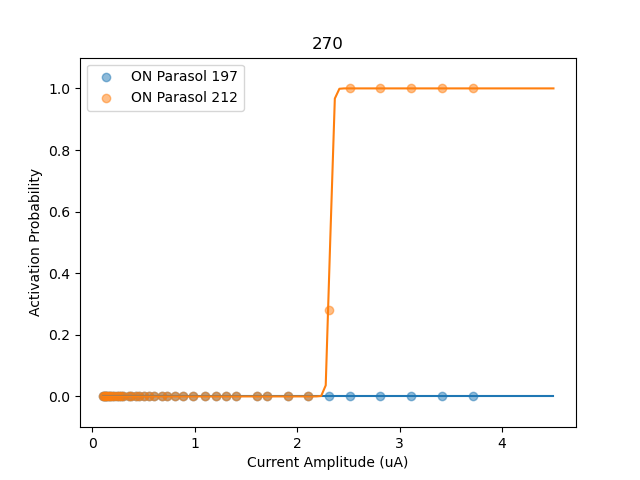

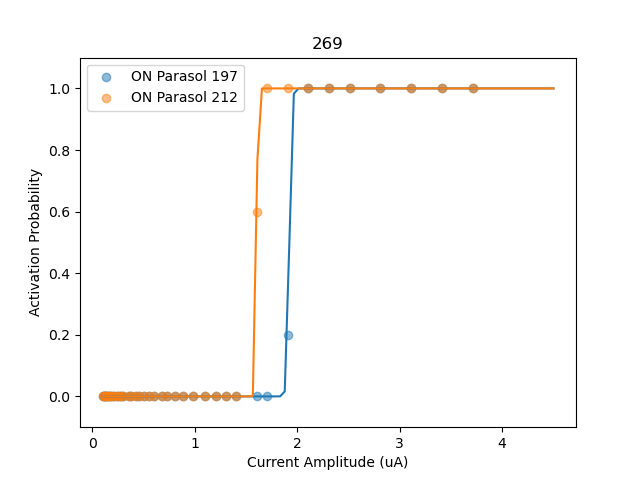

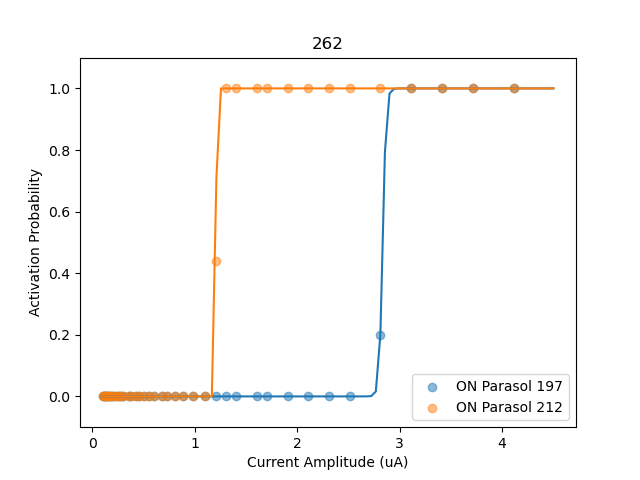

1.1487172333703354e-08

978
0.0019035741573705245
left
598
0.03250589750957433
left
272
0.08424283012486145
left
189
0.12017523868863556
right
83
0.077374311119074
left
52
0.1262823738938238
right
31
0.0783186030728833
left
16
0.07341396705681447
left
6
0.016383209561130374
right
10
0.06396844043904548
right
15
0.09530656534707038
left
7
0.04669260292334276
right
8
0.10989120590537305
right
326
0.04562402165076174
left
155
0.09037928679999463
left
72
0.09365141759673412
left
40
0.12245898060820992
right
32
0.18645989761762316
right
83
0.10849130894864367
right
171
0.055493514373392894
left
83
0.07997547044098452
left
40
0.051871199989492855
left
27
0.0866900889844654
left
12
0.07131537431545198
right
15
0.07955409002261549
left
8
0.07373117770536874
right
7
0.05717713855590889
right
13
0.05909002988980905
right
43
0.15913077716638924
right
88
0.11931951061353852
right
380
0.041503644795894856
left
111
0.048602895506330235
left
56
0.08236678162439637
left
24
0.05626581009539544
left
13


/tmp/ipykernel_71267/2804144847.py:52: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


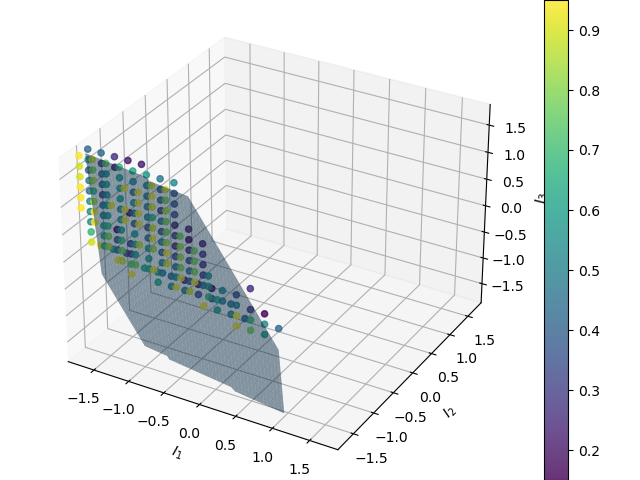

[-17.27405845  -2.0874214   -9.19411518   1.2397222 ]


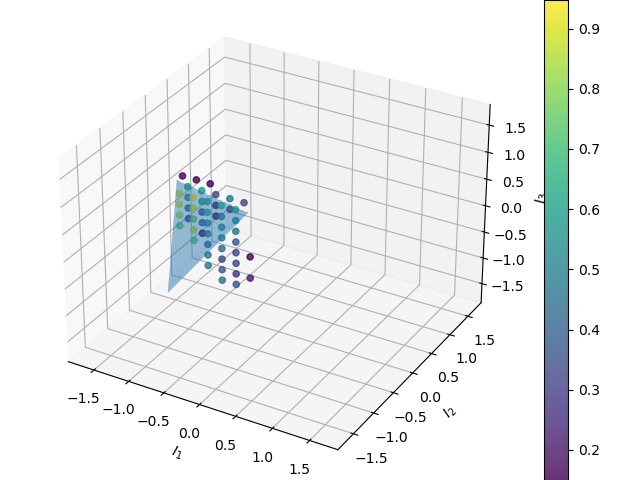

[nan]
[nan]
[nan]
[nan]
[-19.46849537  -3.23146778 -10.86824681  -6.97768572]


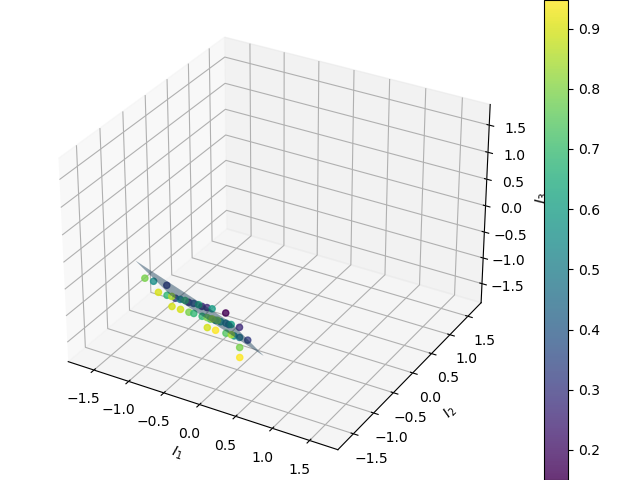

[-26.59084809  -6.31881955 -10.17671748 -13.87656679]


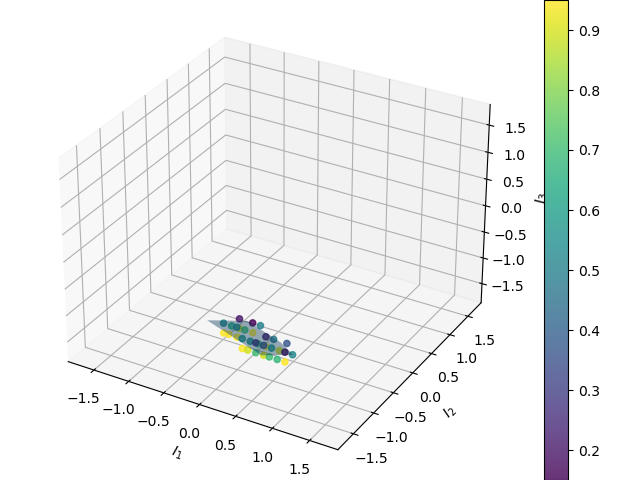

[-11.52546004  -0.75982498  -5.88986965  -4.62699573]


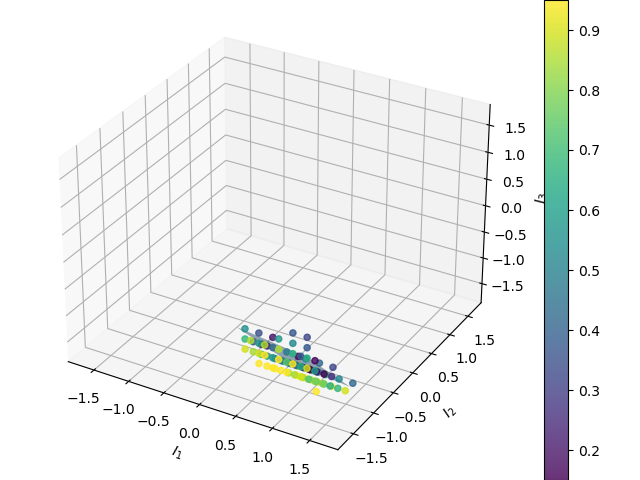

[nan]
[nan]
[nan]
[nan]
[-27.34339443  -2.59815083  -2.18968035 -14.49554666]


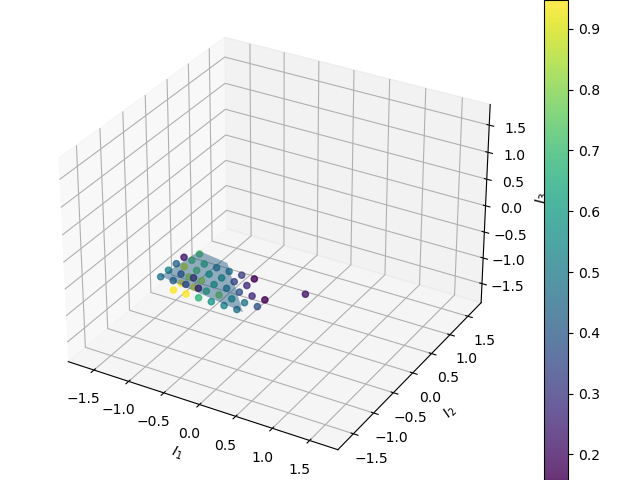

[-13.66120108  -1.94801553  -6.8546187   -6.91293197]


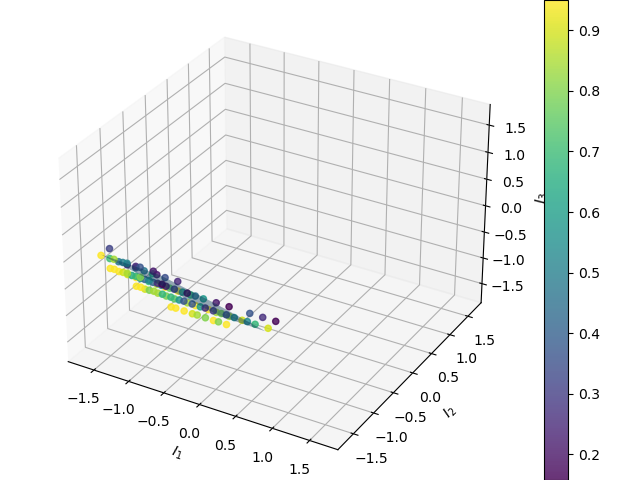

[nan]
[nan]
[-16.63561428   1.73952926   6.93183119  -1.94953791]


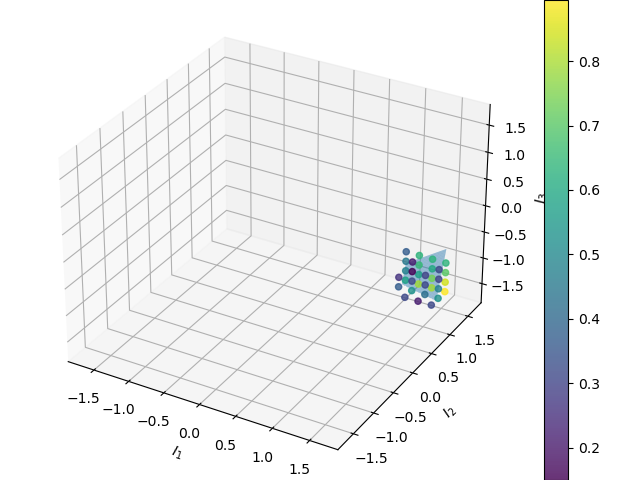

[-16.05854191   3.29883545   8.17936701   2.51764555]


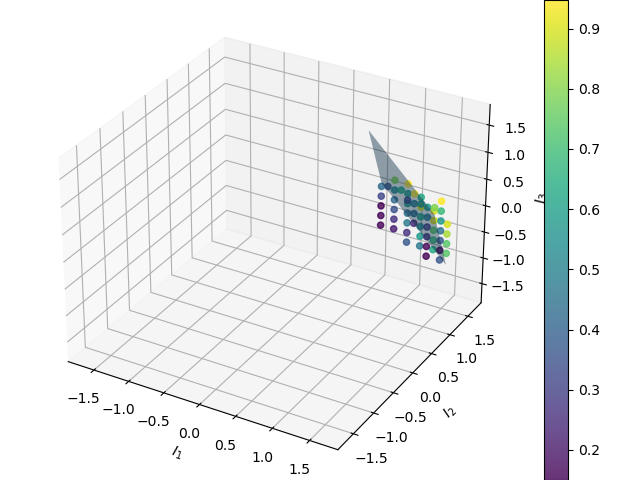

[-13.81261819   3.02014882   6.97530665   5.28655288]


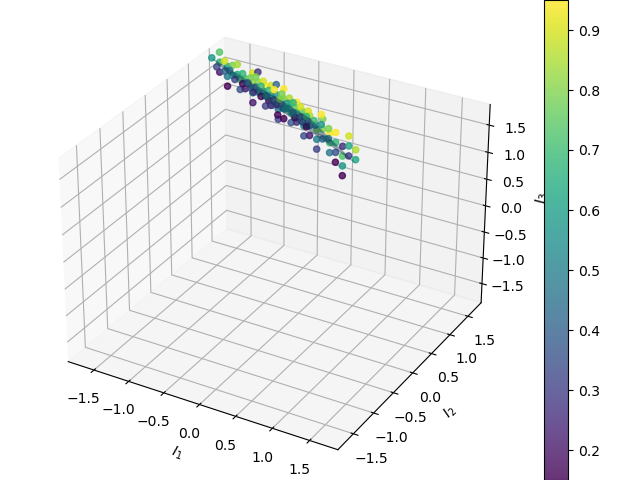

[-19.60575072   3.85410657   9.99424986   6.08719986]


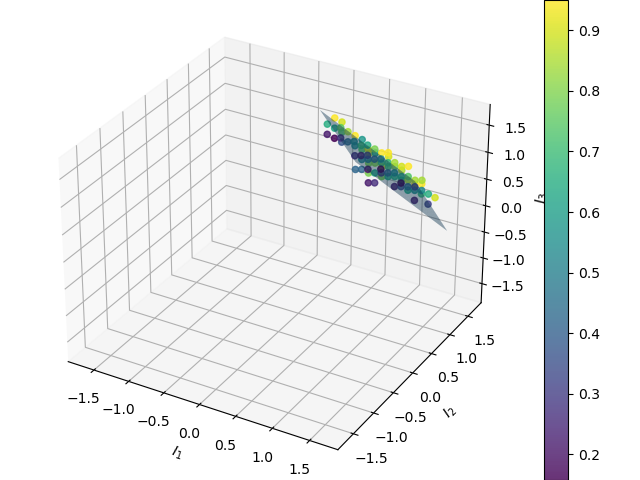

[-20.61112975   3.98352168   6.82863701   9.47725462]


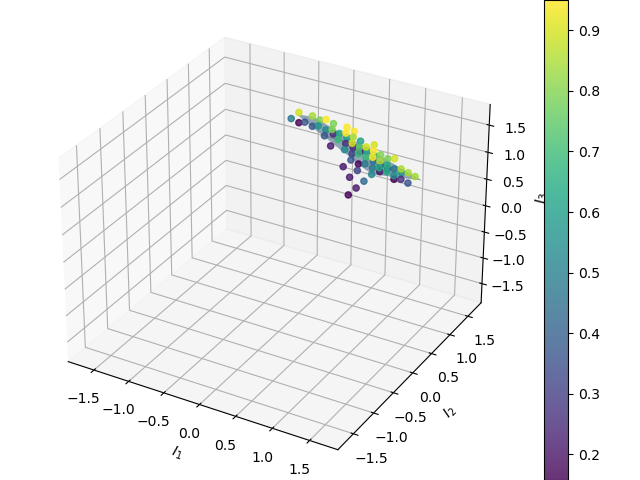


1181
0.00015045509296007786
left
574
0.12251572954283896
right
607
0.06817892859663877
left
213
0.07695208970472345
left
106
0.08851799553743578
left
44
0.13408978523877113
right
62
0.08585750885329213
left
30
0.1576400599179637
right
32
0.05525102298295159
left
18
0.03585554566226168
left
11
0.04176422624348952
right
7
0.1981339728666479
right
14
0.13200086357828145
right
107
0.1451124345656809
right
394
0.15407580388883535
[-6.79941285  3.85834516  3.63125835  5.85770062]


/tmp/ipykernel_71267/2804144847.py:52: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


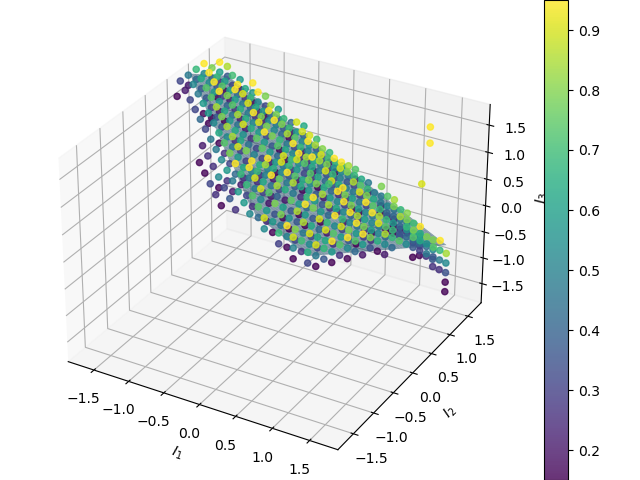

[-11.71528293  -5.76863563  -6.09082692  -7.46364983]


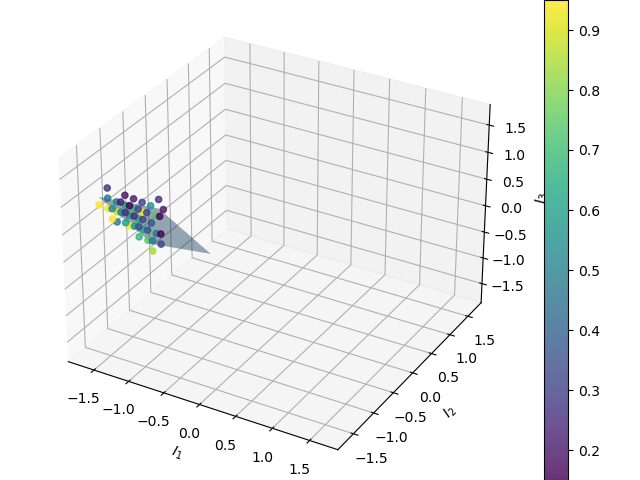

[-17.73912474  -6.47366105  -8.89865934  -5.36108668]


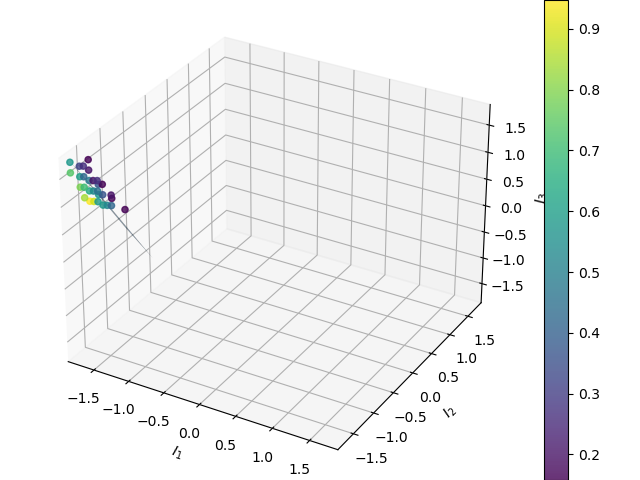

[nan]
[nan]
[nan]
[-10.80406815  -5.84261241  -6.19076772  -8.88832247]


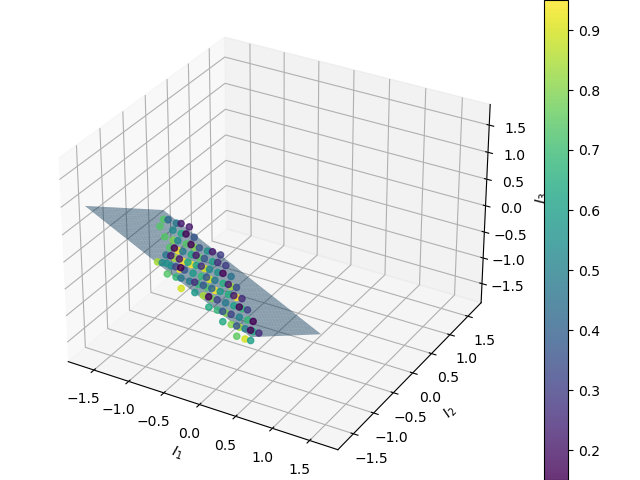

[-10.14096989  -5.04709468  -4.49908607  -9.81738397]


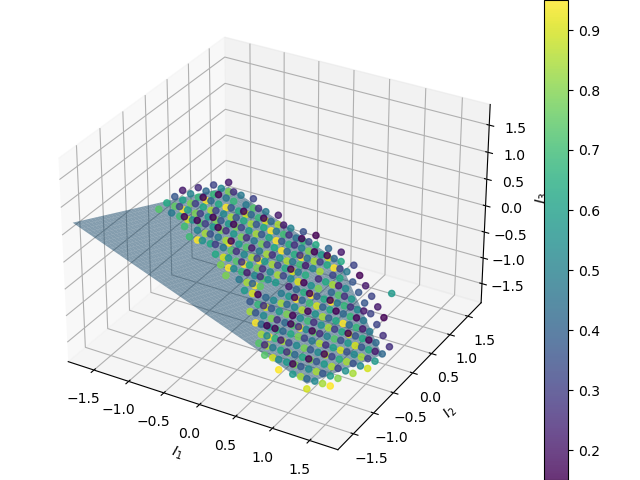

0
Optimal value 0.1861473720225145
optimal p_t 0.8720320119772681
optimal p_n 0.03790692825663533
optimal T_t -1.919045995149656
optimal T_n -3.2339772951728882
[-1.2672653  -1.78125     1.78124998]
1
Optimal value 0.03975968988095849
optimal p_t 0.9708119057837098
optimal p_n 0.009600964442202065
optimal T_t -3.5043718438565374
optimal T_n -4.636244371982135
[-1.0506541  -1.78124997  1.78124995]
2
Optimal value 0.8045035770272423
optimal p_t 0.6893260662562296
optimal p_n 0.2613446207159992
optimal T_t -0.796970487100171
optimal T_n -1.0389915560647318
[ 1.39999999 -1.78125    -0.77826035]
3
Optimal value 13.16434374682605
optimal p_t 0.16286947761505538
optimal p_n 0.8891900199714429
optimal T_t 1.6370308698480516
optimal T_n 2.082494115706386
[ 1.39999999 -1.78124996 -1.12944987]
4
Optimal value 0.49576998289682545
optimal p_t 0.7541238406764792
optimal p_n 0.14510027636716258
optimal T_t -1.1207286076590253
optimal T_n -1.7735591152026822
[ 1.39999999 -1.78124999 -0.69561623]
5
Opt

/tmp/ipykernel_71267/3675145641.py:42: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


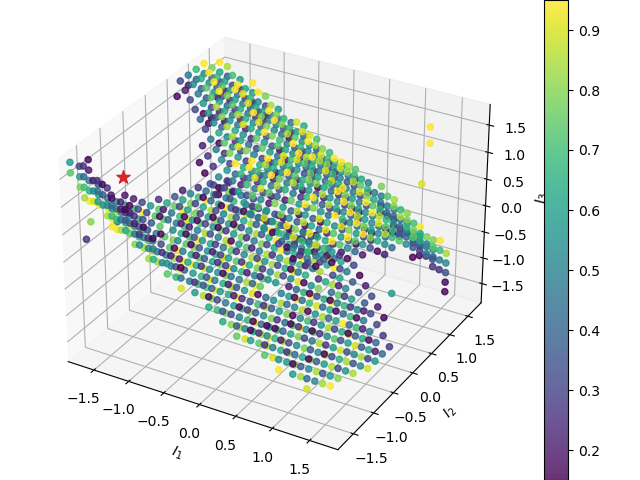

/tmp/ipykernel_71267/3675145641.py:62: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


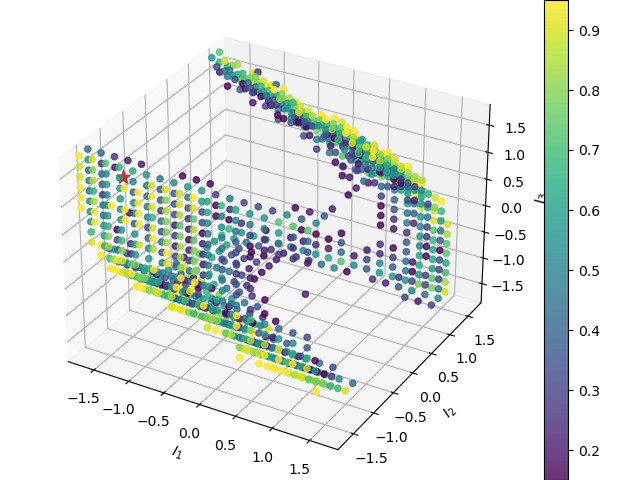

In [26]:
for m in range(len(all_targets)):
    m = 0
    print(m)
    targets = all_targets[m]
    nontargets = all_nontargets[m]

    classification = classifySelectivity(targets, nontargets)
    print(targets, nontargets, classification)
    
    best_1elec = get1elecSelectivity(dataset, electrical_path, gsort_path_1elec, estim_1elec, 
                                     wnoise, p, targets, nontargets, spont_limit=0.15, noise_limit=0.1, show_plots=True)
    
    print(best_1elec)
    
    t_weights, t_amps, t_probs = fitMultielecSurface(electrical_path, gsort_path, dataset, estim, wnoise, p,
                                                     targets, downsample=False, downsample_trials=10, 
                                                     downsample_factor=2, load_from_mat=True, R2_thr=0.1, 
                                                     min_points_per_cluster=15, show_plots=True, verbose=True)
    nt_weights, nt_amps, nt_probs = fitMultielecSurface(electrical_path, gsort_path, dataset, estim, wnoise, p,
                                                        nontargets, downsample=False, downsample_trials=10, 
                                                        downsample_factor=2, load_from_mat=True, R2_thr=0.1, 
                                                        min_points_per_cluster=15, show_plots=True, verbose=True)
    
    target_combos_flat = cartesian_product_pp(t_weights)
    target_combos = np.reshape(target_combos_flat, (len(target_combos_flat), len(targets), 
                                                int(target_combos_flat.shape[-1] / len(targets))))
    
    nt_weights = np.vstack((nt_weights))

    selec_vals, x_vals = computeSelecVec(target_combos, nt_weights, verbose=True)
    print(selec_vals, x_vals)
    selec_vec = x_vals[np.argsort(selec_vals)[-1]]
    print(selec_vec)
    best_multielec = np.amax(selec_vals)
    print(best_multielec)
    
    selec_comparison.append((best_1elec, best_multielec, classification))
    
    for i in range(len(nt_amps)):
        fig = plt.figure()
        fig.clear()
        ax = Axes3D(fig)
        plt.xlabel(r'$I_1$')
        plt.ylabel(r'$I_2$')
        plt.xlim(-1.8, 1.8)
        plt.ylim(-1.8, 1.8)
        ax.set_zlim(-1.8, 1.8)
        ax.set_zlabel(r'$I_3$')

        scat = ax.scatter(nt_amps[i][:, 0], 
                    nt_amps[i][:, 1],
                    nt_amps[i][:, 2], marker='o', s=20, c=nt_probs[i], alpha=0.8)

        ax.scatter(selec_vec[0], selec_vec[1], selec_vec[2], c='tab:red', marker='*', s=100)

        clb = plt.colorbar(scat)
        plt.show()
        
    for i in range(len(t_amps)):
        fig = plt.figure()
        fig.clear()
        ax = Axes3D(fig)
        plt.xlabel(r'$I_1$')
        plt.ylabel(r'$I_2$')
        plt.xlim(-1.8, 1.8)
        plt.ylim(-1.8, 1.8)
        ax.set_zlim(-1.8, 1.8)
        ax.set_zlabel(r'$I_3$')

        scat = ax.scatter(t_amps[i][:, 0], 
                    t_amps[i][:, 1],
                    t_amps[i][:, 2], marker='o', s=20, c=t_probs[i], alpha=0.8)

        ax.scatter(selec_vec[0], selec_vec[1], selec_vec[2], c='tab:red', marker='*', s=100)

        clb = plt.colorbar(scat)
        plt.show()

    break

In [27]:
selec_comparison

[(1.1487172333703354e-08, 0.961491175196214, 'ON/ON')]

In [ ]:
plt.figure()
for i in range(len(selec_comparison)):
    if selec_comparison[i][2] == 'ON/OFF':
        color = 'tab:blue'
    if selec_comparison[i][2] == 'ON/ON':
        color = 'tab:red'
    if selec_comparison[i][2] == 'OFF/OFF':
        color = 'tab:orange'
    if selec_comparison[i][2] == 'mixed':
        color = 'tab:purple'
    plt.scatter(np.array(selec_comparison)[i, 0].astype(float), 
                np.array(selec_comparison)[i, 1].astype(float), alpha=0.5, c=color)
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), linestyle='--', c='k')
plt.xlabel('Single-electrode selectivity')
plt.ylabel('Triplet selectivity')
leg = plt.legend(['OFF/OFF'])#, 'ON/ON', 'OFF/OFF', 'mixed'])
leg.legendHandles[0].set_color('tab:orange')
# leg.legendHandles[1].set_color('tab:red')
# leg.legendHandles[2].set_color('tab:orange')
# leg.legendHandles[3].set_color('tab:purple')